In [1]:
import pandas as pd
import pydotplus
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df['datetime'] =  pd.to_datetime(df['datetime'])

# Удаляем корреляции (по описанию casual + registered = count as target) 

In [4]:
df.corr()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
season,1.000000,0.029368,-0.008126,0.008879,0.258689,0.264744,0.190610,-0.147121,0.096758,0.164011,0.163439
holiday,0.029368,1.000000,-0.250491,-0.007074,0.000295,-0.005215,0.001929,0.008409,0.043799,-0.020956,-0.005393
workingday,-0.008126,-0.250491,1.000000,0.033772,0.029966,0.024660,-0.010880,0.013373,-0.319111,0.119460,0.011594
weather,0.008879,-0.007074,0.033772,1.000000,-0.055035,-0.055376,0.406244,0.007261,-0.135918,-0.109340,-0.128655
temp,0.258689,0.000295,0.029966,-0.055035,1.000000,0.984948,-0.064949,-0.017852,0.467097,0.318571,0.394454
atemp,0.264744,-0.005215,0.024660,-0.055376,0.984948,1.000000,-0.043536,-0.057473,0.462067,0.314635,0.389784
humidity,0.190610,0.001929,-0.010880,0.406244,-0.064949,-0.043536,1.000000,-0.318607,-0.348187,-0.265458,-0.317371
windspeed,-0.147121,0.008409,0.013373,0.007261,-0.017852,-0.057473,-0.318607,1.000000,0.092276,0.091052,0.101369
casual,0.096758,0.043799,-0.319111,-0.135918,0.467097,0.462067,-0.348187,0.092276,1.000000,0.497250,0.690414
registered,0.164011,-0.020956,0.119460,-0.109340,0.318571,0.314635,-0.265458,0.091052,0.497250,1.000000,0.970948


In [5]:
df = df.drop(['registered', 'casual'], axis=1)
df = df.set_index('datetime')

# Собираем дерево, сплитим данные, смотрим на mse (в контесте rmselog) 

In [6]:
from sklearn import tree
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

y = df['count']
x = df.drop('count', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=42)


model = tree.DecisionTreeRegressor()
model.fit(x_train,y_train)

mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))

37181.93003665714

# Сорян, ноутбук говорит, что стандартный DTR слишком велик, уже начинаем крутить параметры

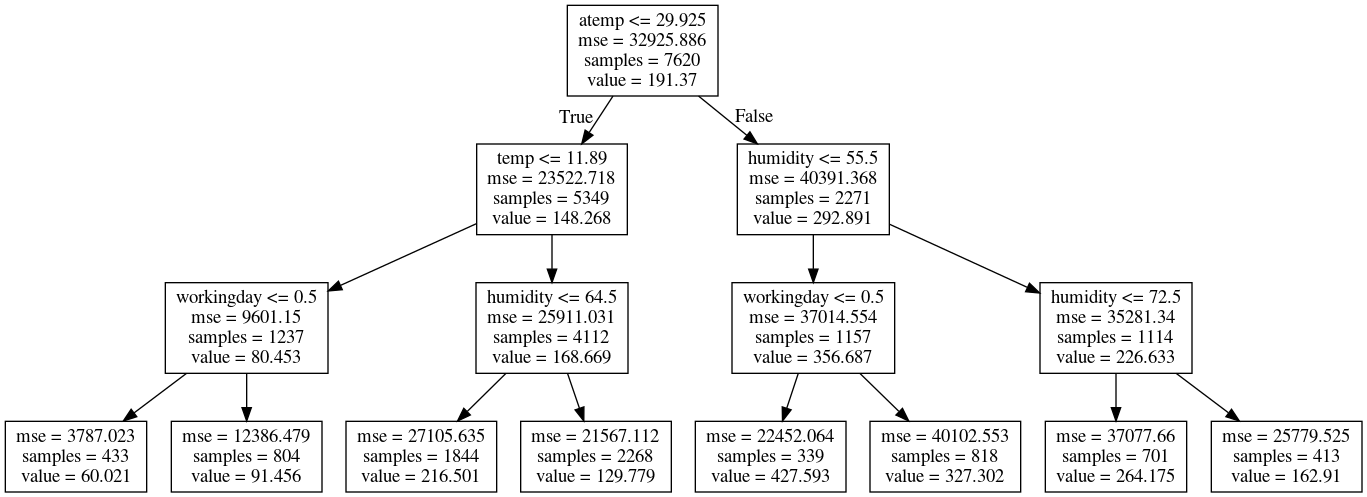

In [7]:
model = tree.DecisionTreeRegressor(max_depth=3)
model.fit(x_train,y_train)

dt_graphviz = tree.export_graphviz(model, out_file = None,feature_names = x_train.columns)
pydot_graph = pydotplus.graph_from_dot_data(dt_graphviz)

Image(pydot_graph.create_png())

In [8]:
importance = model.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance

,Importance
season,0.000000
holiday,0.000000
workingday,0.042446
weather,0.000000
temp,0.116822
atemp,0.526368
humidity,0.314363
windspeed,0.000000


# Крутим парочку параметров, наблюдаем почти +50% к карме и визуально менее читаемо (глубина все дела) 

In [9]:
x_train = x_train[['season', 'workingday', 'weather', 'temp', 'atemp','humidity', 'windspeed']]
x_test = x_test[['season', 'workingday', 'weather', 'temp', 'atemp','humidity', 'windspeed']]

model = tree.DecisionTreeRegressor(max_depth=6,max_leaf_nodes=50)
model.fit(x_train,y_train)

mean_squared_error(y_true=y_test, y_pred=model.predict(x_test))

22304.696800342044

In [10]:
importance = model.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])
importance

,Importance
season,0.075779
workingday,0.033621
weather,0.013957
temp,0.141149
atemp,0.396665
humidity,0.317292
windspeed,0.021538


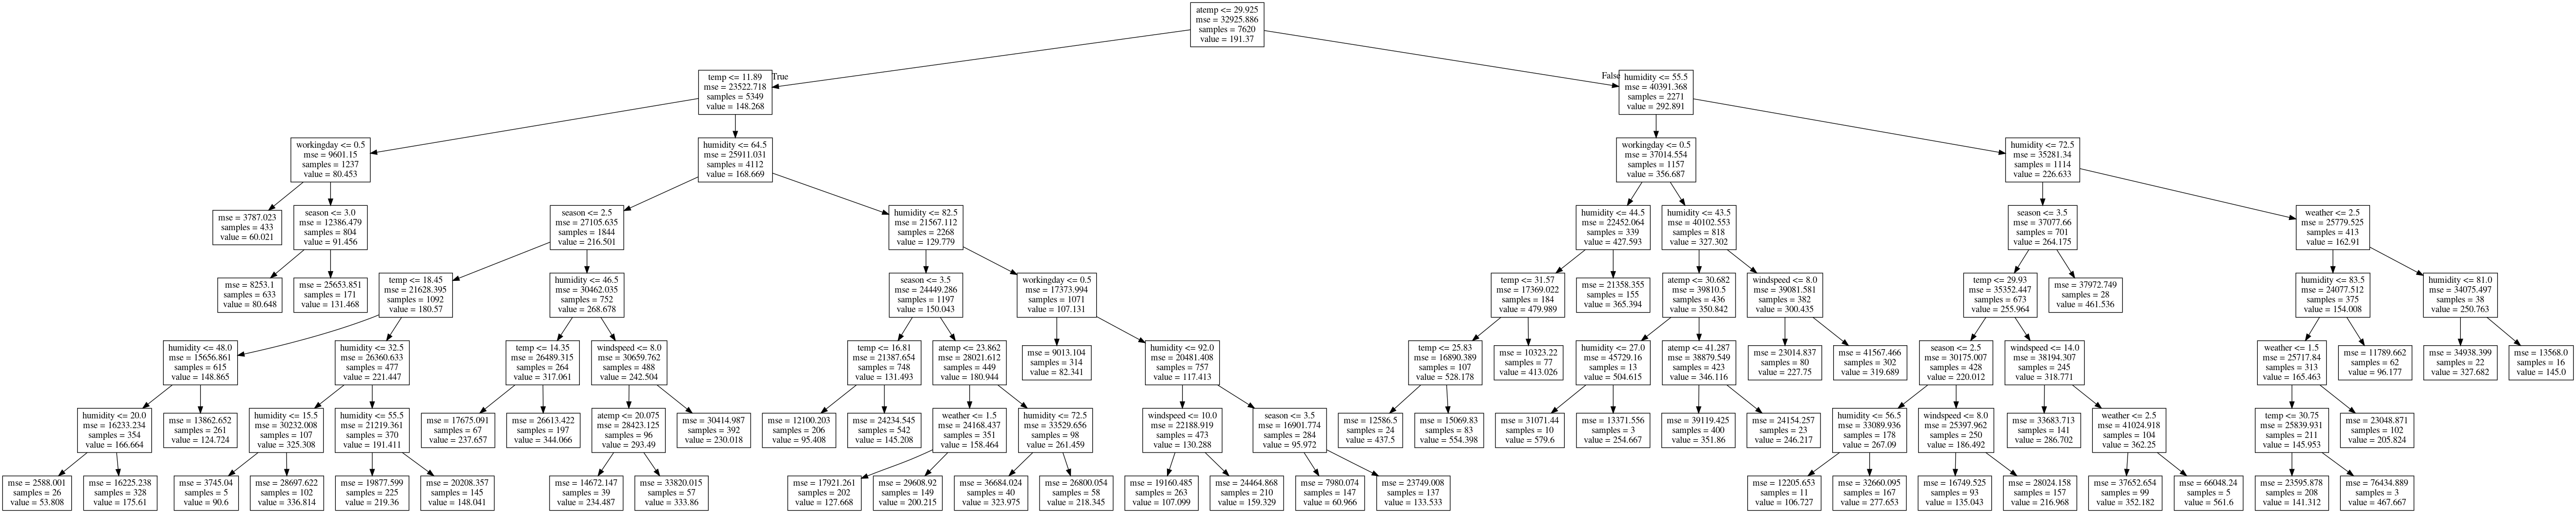

In [11]:
dt_graphviz = tree.export_graphviz(model, out_file = None,feature_names = x_train.columns)
pydot_graph = pydotplus.graph_from_dot_data(dt_graphviz)
Image(pydot_graph.create_png())